# MCC-F1 Curve and Metrics

Based on the paper - The MCC-F1 curve: a performance evaluation technique for binary classification (Cao, Chicco, & Hoffman, 2020), wherein the authors combine two single-threshold metrics i.e. Matthews correlation coefficient (MCC) and the 𝐹1 score.
into a MCC-F1 curve and also compute a metric that integrates the MCC-F1 curve inorder to compare classifier performance across varying thresholds.

The below code computes the MCC-F1 curve and its relevant metrics.
* Based on 2 input values - Ground truths and Predicted values (given by a binary classifer);
* The MCC-F1 function calculates the MCC and F1 scores across varying thresholds.
* The MCC-F1 metric provides a measure to compare classifers, and provides the the best threshold 𝑇 the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1)
* Plotting the MCC-F1 curve.

***

# Import Necessary Python Packages

In [1]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# The MCC-F1 function:
Based on the inputs of ground truths and predicted values; we can calculate Matthews correlation coefficient (MCC) and the 𝐹1 scores which are scoring classifiers. 
This results in a real-valued prediction score 𝑓(𝑥𝑖) for each element, and then assigning positive predictions (𝑦𝑖̂ = 1) when the score exceeds some threshold 𝜏, or negative predictions (𝑦𝑖̂ = 0).

In [2]:
def mcc_f1(ground_truths, predicted_values):
    
    """
    The function mcc_f1 calculates MCC and F1 scores based on varying thresholds identifed by the PRC function
    based on inputs -  ground truth vaules and predicted values.
    
    Parameters
    ----------
    ground_truths, predicted_values : numpy.ndarray;
                        Input arrays; groundtruth values (True values) and predicted values.
    
    Returns
    -------
    mcc, f1, thresholds: numpy.ndarray;
                           Output arrays; Unit normalized MCC scores and F1 score values 
                           for every threshold.           
    """
    
    mcc = []   
    f1 = []
    
    # Generating thresholds with the PRC function
    precision, recall, thresholds = metrics.precision_recall_curve(
                                    ground_truths, predicted_values)

    # For every value of the thresholds (cutoffs), calculate MCC and F1 scores :
    for T in thresholds:
        predicted_values_after_cutoff = predicted_values > T  # Positive classes are determined for every predicted value that exceeds the threshold. 
    
        mcc.append((metrics.matthews_corrcoef(
                    ground_truths, predicted_values_after_cutoff)+1)*0.5) # get normalised MCC: change the range of MCC from [-1, 1] to [0, 1] 
        
        f1.append(metrics.f1_score(
                    ground_truths, predicted_values_after_cutoff))
        
    mcc = np.array(mcc)
    f1 = np.array(f1)  
    
    # Resulting values are an array of MCC & F1 scores across different thresholds (cutoffs)  
    return mcc,f1, thresholds


# The MCC-F1 metric:

Based on the MCC-F1 scores calulated we can compute the MCC-F1 Metric based on the following steps:
* Divide the normalized MCC in the curve [min𝑖 𝑋𝑖, max𝑖 𝑋𝑖] into 𝑊 = 100 sub-ranges, each of width 𝑤 = (max𝑖 𝑋𝑖 − min𝑖 𝑋𝑖)/𝑊.
* calculate the mean Euclidean distance between points with MCC in each sub-range to the point of perfect performance (1,1).
* Calculate grand average i.e. averaged the mean distances amongst subranges.
* Better classifiers have MCC-𝐹1 curves closer to the point of perfect performance (1,1), and have a larger MCC-𝐹1 metric.

In [3]:
def MCC_F1_Metric(mcc,f1,thresholds, W_num_of_subranges = 100):
    
    """
    MCC_F1_Metric function computes the MCC-F1 metric i.e. the average distances between the predcition scores to the point of Perfect Performace (1,1) 
    and also results in the best threshold value
    
    Parameters
    ----------
    
    mcc,f1, thresholds : numpy.ndarray;
                        MCC and F1 scores across varying thresholds
    
    W_num_of_subranges : int, optional;
        Number of subranges- default = 100; 
        larger values of 𝑊 will cause the MCC-𝐹1 metric to capture the performance of a classifier more accurately.
    
    Returns
    -------
    MCC_F1_Met : float;
                The ratio of the average distance of the MCC-F1 score to the Point of Perfect Performace (1,1)
                A metric to compare classifier performance.
    
    Best_threshold : int;
                Index of the best prediction score threshold (𝑇), 
                Index of the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
    
    """
    
     
    subrange_intervals = np.linspace(np.min(mcc), np.max(mcc),W_num_of_subranges) # breaking into subranges
    
    # Computing MCC values per subrange
    
    values_per_subrange = np.zeros_like(subrange_intervals) # 'n' is the number of points per subrange
    for i in range(W_num_of_subranges-1):
        for j in mcc:
            if j >= subrange_intervals[i] and j < subrange_intervals[i+1]:
                values_per_subrange[i] = values_per_subrange[i] + 1

    # Calculating the distances between points in a subrange to the Point of perfect performance (1,1)            
    Distance_of_points_within_subrange = np.sqrt(((mcc-1)**2)+((f1-1)**2)) # calculating the Euclidean distance 𝐷𝑖            
    sum_of_distance_within_subrange = np.zeros_like(subrange_intervals)
    index = -1
    for value in mcc:
        index += 1
        for i in range(W_num_of_subranges-1):
                 if value >= subrange_intervals[i] and value < subrange_intervals[i+1]:
                        sum_of_distance_within_subrange[i] = sum_of_distance_within_subrange[i] + Distance_of_points_within_subrange[index]

    # Mean Distance across subranges
    mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange/values_per_subrange)
    total_number_of_subranges = 0  
    total_sum_of_mean_distances = 0
    for i in mean_Distance_per_subrange:
        if not np.isnan(i):
            total_number_of_subranges += 1 
            total_sum_of_mean_distances += i # addition of all the means across subranges that have atleast 1 MCC value.

    grand_mean_distance = total_sum_of_mean_distances/total_number_of_subranges # P = total number of subranges that have atleast 1 MCC value
   
    """ 
    Compare the grand average distance to √2 (The distance between the point of worst performance (0,0) and 
    the point of perfect performance (1,1) is √2).That is the maximum possible distance between a point on the MCC-𝐹1 curve
    The ratio between the grand avgerage distance and √2 is taken.
    This ratio ranges between 0 and 1 (worst value = 0; best value = 1). To get the MCC-𝐹1 score, we subtract this ratio from 1
    """

    MCC_F1_Met = 1 - (grand_mean_distance /np.sqrt(2))
  
    
    # Finding the best threshold 𝑇 the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
   
    result = np.where(Distance_of_points_within_subrange == Distance_of_points_within_subrange.min())
    Best_threshold = result[0][0]
    
    print("MCC-F1 metric = {0:.2f}".format(MCC_F1_Met), "Best Threshold = {0:.2f}".format(thresholds[Best_threshold]))
    
    return MCC_F1_Met,Best_threshold

# Ploting function- MCC-F1 curve:

In [4]:
# Generating a plot (the overall canvas);
axis = None
def axis_plotting(total_plots): 
    global axis
    if axis == None:
        fig = plt.figure(figsize=(7,7))
        axis = []        
        for i in range(1,total_plots+1):
            ax = fig.add_subplot(total_plots, 1, i)
            axis.append(ax)
            
    
def plotting(mcc, f1, thresholds,MCC_F1_Met,Best_threshold,classifer_name = "",total_plots = 1,ax = 0):
    
        """
        Plotting function - fuction to plot the MCC and F1 scores (across varying Thresholds), and highlight the the MCC_F1 metric with the best threshold
        For multiple plots, 'total_plots' should be > 1 AND 'ax' (< total_plots) starting from  1
    
        Parameters
        ----------
        mcc,f1 : numpy.ndarray;
            MCC and F1 scores across varying thresholds
    
        MCC_F1_Met : float;
                The ratio of the average distance of the MCC-F1 score to the Point of Perfect Performace (1,1)
                A metric to compare classifier performance.
    
        Best_threshold : int;
                Index of the best prediction score threshold (𝑇), 
                Index of the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
                
        classifer_name : str, optional
                    default = ""
    
        total_plots: int, optional
                    Number of sub-plots to generate; default = 1
    
        ax : int, optional
            Index of subplot ([1,2,3...]); default = None
    
                            
        Returns
        -------
        
        MCC-F1 curve: 
            for multiple sublplots, adjust total_plots and ax input value.
                        
        """
        
        global axis
        if total_plots > 1 and ax < total_plots: # if more than 1 total plot is mentioned;
            axis_plotting(total_plots) #calling function to generate plot;
            if ax == 0:
                subplot = plt.gca() # plot on current axis value, 
            else:
                subplot = axis[ax-1] # plotting additional graphs based on index of the axis.
        elif ax > total_plots:
            print("Index inconsistent with total_plots")
        else:
            axis = None
            subplot = plt.gca() # plot on base plot if no additional subplots are needed
      
        # Labelling the plot;
        subplot.plot(f1,mcc)
        subplot.annotate(classifer_name + "_MCC_Met - {0:.2f}".format(
            MCC_F1_Met), 
                 (f1[Best_threshold],mcc[Best_threshold]), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='left') 
        
        subplot.scatter(f1[Best_threshold],mcc[Best_threshold],color='red')
        subplot.set(xlabel='F1 score',
               ylabel='unit−normalized MCC',title='MCC-F1 curve')
        
        # Inserting Random line
        subplot.axhline(0.5,linewidth=0.7, color='green',linestyle='--')
        subplot.annotate('Random line',xy =(0,0.5),xytext=(250,-15),
                    color='g', xycoords = subplot.get_yaxis_transform(), 
                    textcoords="offset points", va="bottom")


        # Displaying and labelling points of performances.

        subplot.scatter(1,1,color = 'black');subplot.scatter(0,0,color = 'black')
        subplot.annotate('Point of Perfect performance',(1,1),
                    textcoords="offset points",xytext=(-9,-2),ha='right')
        subplot.annotate('Point of Worst performance',(0,0)
                    ,textcoords="offset points",xytext=(9,2),ha='left')
        
        subplot.set_xticks(np.arange(0, 1.1, 0.25)); subplot.set_yticks(np.arange(0, 1.1, 0.25))
        subplot.set_xlim(-0.05,1.05); subplot.set_ylim(-0.05,1.05)
        subplot.grid(alpha = 0.3)

# Example

In [5]:
# Populating ground truth values

x = np.array([1,0])
ground_truths = np.repeat(x,[1000,10000])

"""
Populating predicted values (based on a beta distribution, this bimodal piecewise 
distribution simulates a classifier with large recall when the threshold nears 1
and small recall when the threshold nears 0).
"""

b1 = np.random.beta(12,2,300)
b2 = np.random.beta(3,4,700)
b3 = np.random.beta(2,3,10000)
predicted_values = np.concatenate([b1,b2,b3])


# Calling the 2 functions:

In [6]:
mcc,f1,thresholds = mcc_f1(ground_truths,predicted_values)
MCC_F1_Met,T_index = MCC_F1_Metric(mcc,f1,thresholds)


MCC-F1 metric = 0.39 Best Threshold = 0.81


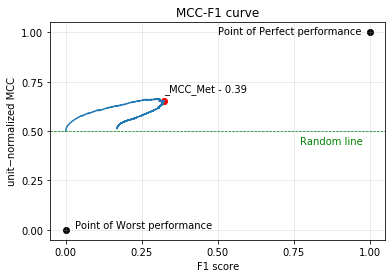

In [7]:
plotting(mcc,f1,thresholds,MCC_F1_Met,T_index)

***

## Example (multiple datasets):

In [8]:
# Populating ground truth values

#Ground truth datasets (x, y,z)
x = np.array([1,0])
ground_truths_x = np.repeat(x,[1000,10000])

y = np.array([1,0])
ground_truths_y = np.repeat(y,[10000,1000])

z = np.array([1,0])
ground_truths_z = np.repeat(z,[10000,10000])

"""
Populating predicted values (based on a beta distribution, this bimodal piecewise 
distribution simulates a classifier with large recall when the threshold nears 1
and small recall when the threshold nears 0).
"""
# prediction scores of classifier A:
x1 = np.random.beta(12,2,300)
x2 = np.random.beta(3,4,700)
x3 = np.random.beta(2,3,10000)
predicted_values_Ax = np.concatenate([x1,x2,x3])

y1 = np.random.beta(12,2,3000)
y2 = np.random.beta(3,4,7000)
y3 = np.random.beta(2,3,1000)
predicted_values_Ay = np.concatenate([y1,y2,y3])

z1 = np.random.beta(12,2,3000)
z2 = np.random.beta(3,4,7000)
z3 = np.random.beta(2,3,10000)
predicted_values_Az = np.concatenate([z1,z2,z3])

#prediction scores of classifier B
X1 = np.random.beta(2,3,10000)
X2 = np.random.beta(4,3,1000)

predicted_values_Bx = np.concatenate([X1,X2])

Y1 = np.random.beta(2,3,1000)
Y2 = np.random.beta(4,3,10000)

predicted_values_By = np.concatenate([Y1,Y2])

Z1 = np.random.beta(2,3,10000)
Z2 = np.random.beta(4,3,10000)

predicted_values_Bz = np.concatenate([Z1,Z2])


In [9]:
#Ax
mcc_Ax,f1_Ax,thresholds_Ax = mcc_f1(ground_truths_x,predicted_values_Ax)
MCC_F1_Met_Ax,T_index_Ax = MCC_F1_Metric(mcc_Ax,f1_Ax,thresholds_Ax)

#Bx
mcc_Bx,f1_Bx,thresholds_Bx = mcc_f1(ground_truths_x,predicted_values_Bx)
MCC_F1_Met_Bx,T_index_Bx = MCC_F1_Metric(mcc_Bx,f1_Bx,thresholds_Bx)

#Ay

mcc_Ay,f1_Ay,thresholds_Ay = mcc_f1(ground_truths_y,predicted_values_Ay)
MCC_F1_Met_Ay,T_index_Ay = MCC_F1_Metric(mcc_Ay,f1_Ay,thresholds_Ay)

#By

mcc_By,f1_By,thresholds_By = mcc_f1(ground_truths_y,predicted_values_By)
MCC_F1_Met_By,T_index_By = MCC_F1_Metric(mcc_By,f1_By,thresholds_By)

#Az

mcc_Az,f1_Az,thresholds_Az = mcc_f1(ground_truths_z,predicted_values_Az)
MCC_F1_Met_Az,T_index_Az = MCC_F1_Metric(mcc_Az,f1_Az,thresholds_Az)

#Bz

mcc_Bz,f1_Bz,thresholds_Bz = mcc_f1(ground_truths_z,predicted_values_Bz)
MCC_F1_Met_Bz,T_index_Bz = MCC_F1_Metric(mcc_Bz,f1_Bz,thresholds_Bz)



MCC-F1 metric = 0.38 Best Threshold = 0.80
MCC-F1 metric = 0.28 Best Threshold = 0.04
MCC-F1 metric = 0.37 Best Threshold = 0.21
MCC-F1 metric = 0.51 Best Threshold = 0.01
MCC-F1 metric = 0.50 Best Threshold = 0.27
MCC-F1 metric = 0.31 Best Threshold = 0.00


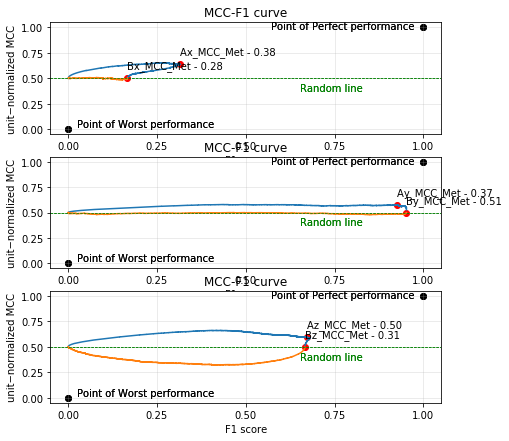

In [10]:
plotting(mcc_Ax,f1_Ax,thresholds_Ax,MCC_F1_Met_Ax,T_index_Ax,'Ax',3,1)
plotting(mcc_Bx,f1_Bx,thresholds_Bx,MCC_F1_Met_Bx,T_index_Bx,'Bx',3,1)

plotting(mcc_Ay,f1_Ay,thresholds_Ay,MCC_F1_Met_Ay,T_index_Ay,'Ay',3,2)
plotting(mcc_By,f1_By,thresholds_By,MCC_F1_Met_By,T_index_By,'By',3,2)

plotting(mcc_Az,f1_Az,thresholds_Az,MCC_F1_Met_Az,T_index_Az,'Az',3,3)
plotting(mcc_Bz,f1_Bz,thresholds_Bz,MCC_F1_Met_Bz,T_index_Bz,'Bz',3,3)

***